# Rasterio: Accessing and Manipulating Raster Bands

Raster datasets often consist of multiple bands, each capturing a different part of the electromagnetic spectrum. For instance, satellite images may include separate bands for red, green, blue, and near-infrared (NIR) wavelengths.

To start, let’s open a multi-band raster dataset.

In [1]:
!pip install rasterio

import rasterio

raster_path = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"

src = rasterio.open(raster_path)
print(src)

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File 

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "/usr/bin/python"
  * The NumPy version is: "1.23.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: /lib/aarch64-linux-gnu/libgomp.so.1: cannot allocate memory in static TLS block


Once the file is opened, we can inspect its metadata to learn about the dataset:

In [3]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -inf,
 'width': 2485,
 'height': 2563,
 'count': 7,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'),
 'transform': Affine(90.0, 0.0, 582390.0,
        0.0, -90.0, 4105620.0)}

This dataset contains multiple bands, each corresponding to a specific wavelength range, as described in the table below:


Name | Wavelength | Description
------|----------|--------
SR_B1 | 0.435-0.451 μm | Band 1 (ultra blue, coastal aerosol) surface reflectance
SR_B2 | 0.452-0.512 μm | Band 2 (blue) surface reflectance
SR_B3 | 0.533-0.590 μm | Band 3 (green) surface reflectance
SR_B4 | 0.636-0.673 μm | Band 4 (red) surface reflectance
SR_B5 | 0.851-0.879 μm | Band 5 (near infrared) surface reflectance
SR_B6 | 1.566-1.651 μm | Band 6 (shortwave infrared 1) surface reflectance
SR_B7 | 2.107-2.294 μm | Band 7 (shortwave infrared 2) surface reflectance

For convenience, let's define a tuple of human-readable band names:

In [7]:
band_names = ("Coastal Aerosol", "Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2")

We can visualize an individual band (for example, Band 5 - NIR) using rasterio’s plotting functionality:

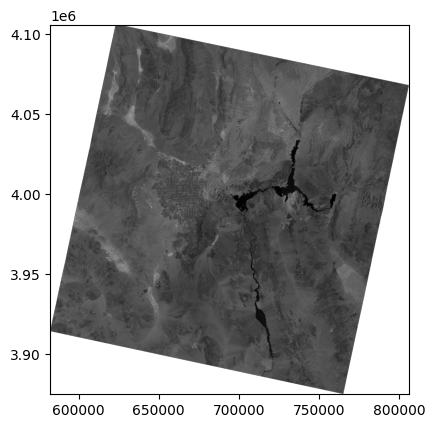

In [4]:
import rasterio.plot

rasterio.plot.show((src, 5), cmap="Greys_r");

To visualize all the bands together, we can create a multi-panel plot, displaying each band with its respective name:

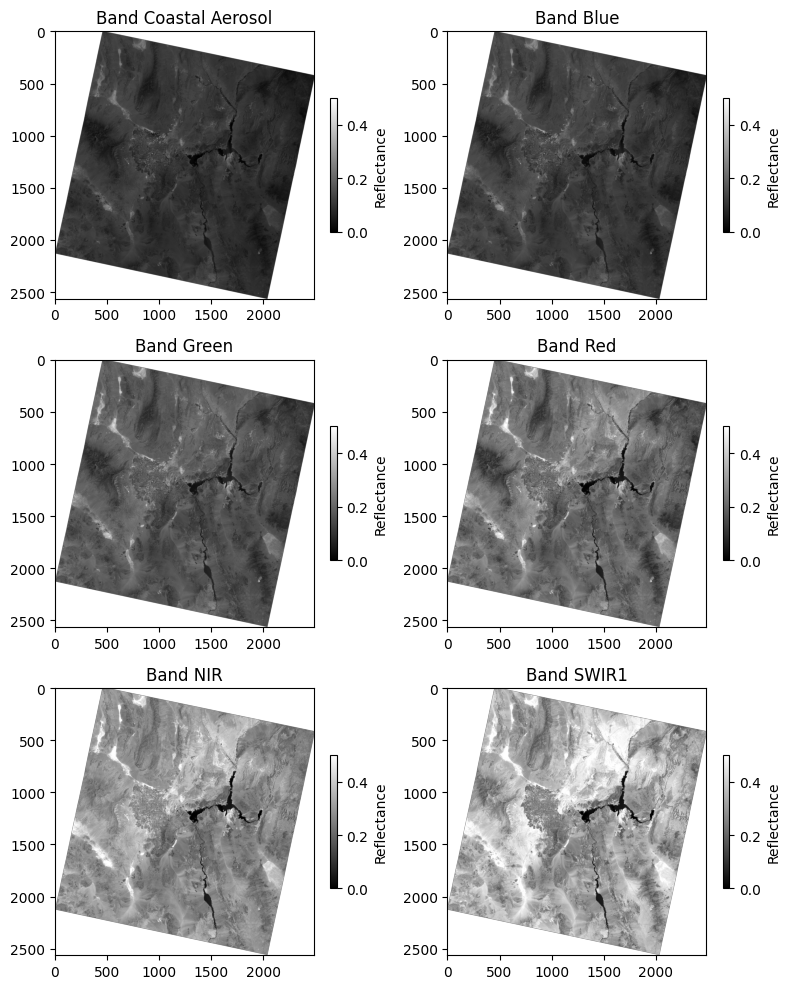

In [8]:
import matplotlib.pylab as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for band in range(1, src.count):
    data = src.read(band)
    ax = axes[band - 1]
    im = ax.imshow(data, cmap="gray", vmin=0, vmax=0.5)
    ax.set_title(f"Band {band_names[band - 1]}")
    fig.colorbar(im, ax=ax, label="Reflectance", shrink=0.5)

plt.tight_layout()
plt.show()

We can combine several bands into a single image by stacking them into an array. For example, we’ll stack the NIR, Red, and Green bands:

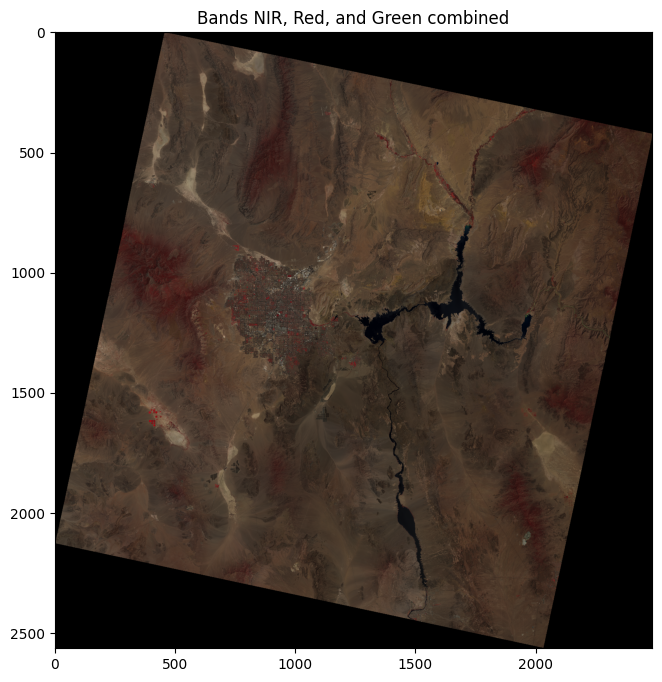

In [10]:
import numpy as np

nir_band = src.read(5)
red_band = src.read(4)
green_band = src.read(3)

# Stack the bands into a single array
rgb = np.dstack((nir_band, red_band, green_band)).clip(0, 1)

# Plot the stacked array
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Bands NIR, Red, and Green combined")
plt.show()

## Basic Band Math (NDVI Calculation)

Band math enables us to perform computations across different bands. A common application is calculating the Normalized Difference Vegetation Index (NDVI), which is an indicator of greeness and vegetation health.

NDVI is calculated as:

```text
NDVI = (NIR - Red) / (NIR + Red)
```

We can compute and plot the NDVI as follows:

<ipython-input-11-b0ce492f3144>:2: RuntimeWarning: invalid value encountered in subtract
  ndvi = (nir_band - red_band) / (nir_band + red_band)


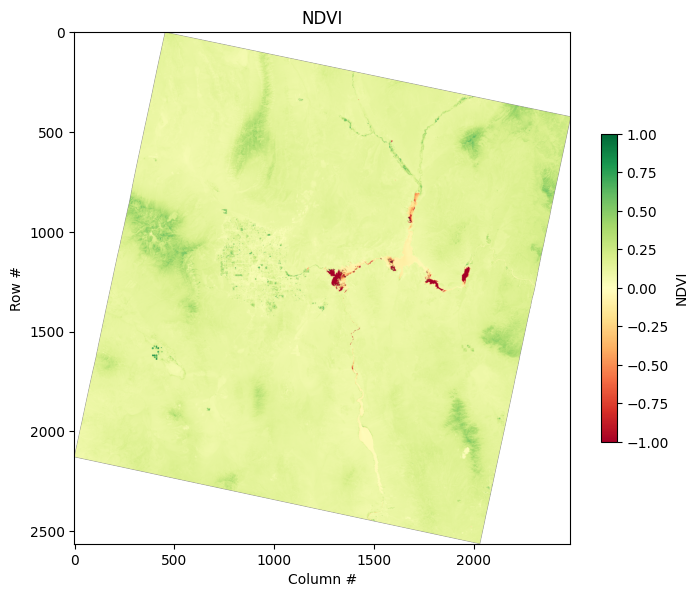

In [11]:
# NDVI Calculation: NDVI = (NIR - Red) / (NIR + Red)
ndvi = (nir_band - red_band) / (nir_band + red_band)

# clip the values below -1 and above 1
ndvi = ndvi.clip(-1, 1)

plt.figure(figsize=(8, 8))

# show the NDVI image
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)

plt.colorbar(label="NDVI", shrink=0.5)
plt.title("NDVI")
plt.xlabel("Column #")
plt.ylabel("Row #")
plt.show()

## Clipping Raster Data

To extract a subset of the raster data, we can either slice the array or use geographic bounds.

First, let's open the sample raster dataset:

In [12]:
raster_path = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"

src = rasterio.open(raster_path)
data = src.read()
data.shape

(7, 2563, 2485)

Then, let’s clip a portion of the raster data using **array indices**:

In [14]:
subset = data[:, 900:1400, 700:1200].clip(0, 1)
rgb_subset = np.dstack((subset[4], subset[3], subset[2]))
rgb_subset.shape

(500, 500, 3)

And plot the stacked array:

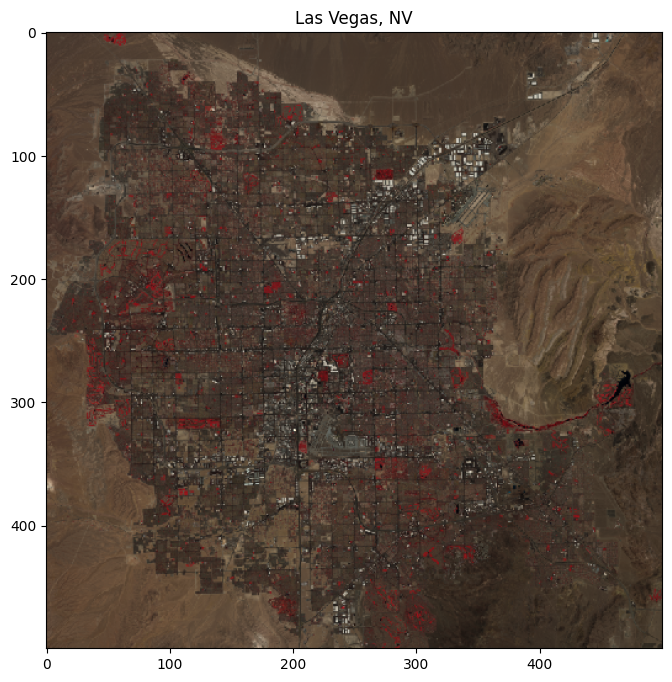

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb_subset)
plt.title("Las Vegas, NV")
plt.show()

Alternatively, we can use a specific geographic window to clip the data.

## Clipping with Vector Data

To clip the raster using vector data (e.g., a GeoJSON bounding box), we can use `rasterio.mask`. First, load the vector data:

In [17]:
!pip install fiona

import fiona
import rasterio.mask
import geopandas as gpd

geojson_path = "https://github.com/opengeos/datasets/releases/download/places/las_vegas_bounds_utm.geojson"
bounds = gpd.read_file(geojson_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 69.5 MB/s eta 0:00:00


Visualize the raster and vector data together:

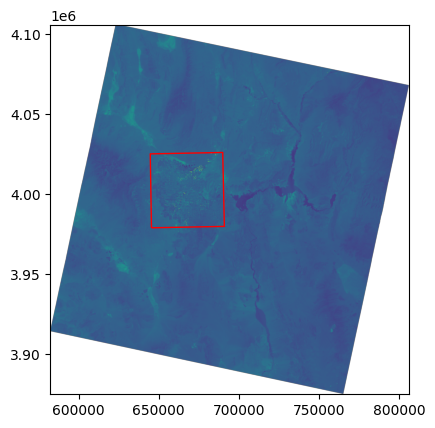

In [19]:
fig, ax = plt.subplots()
rasterio.plot.show(src, ax=ax)
bounds.plot(ax=ax, edgecolor="red", facecolor="none");

Next, apply the mask to extract only the area within the vector bounds:

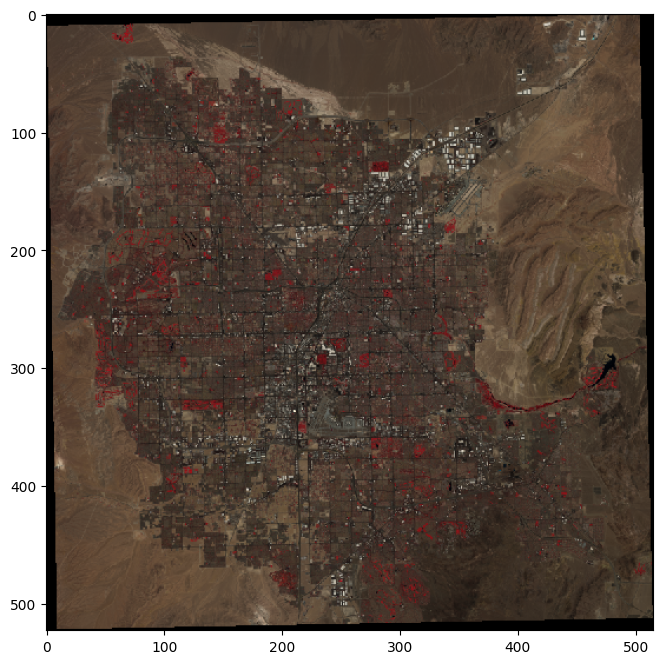

In [26]:
with fiona.open(geojson_path, "r") as f:
    shapes = [feature["geometry"] for feature in f]

out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)

plt.figure(figsize=(8, 8))
plt.imshow(np.dstack((out_image[4], out_image[3], out_image[2])))
plt.show();

What difference do you observe compared to the subset you created earlier? Also check the `out_transform`.

## Summary

Rasterio is a powerful and flexible tool for handling geospatial raster data in Python. Whether you are visualizing satellite imagery, performing raster math, or saving new datasets, it offers a convenient interface for working with raster data. The examples and exercises provided should help you gain hands-on experience with Rasterio, enabling you to work more confidently with geospatial data in various applications.